In [1]:
! pip install sklearn

     |████████████████████████████████| 6.7MB 3.4MB/s eta 0:00:01
     |████████████████████████████████| 296kB 14.0MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=2397 sha256=634b67e740efa291becf092e55d1b5a332244cebc05dfa9e1b7bec2b55e3cf59
  Stored in directory: /root/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
You should consider upgrading via the 'pip install --upgrade pip' command.


# Imports

In [2]:
from fastai.text import *

In [3]:
import sys

sys.path.append("../../../")
from eval.exp.nb_evaluation import *
# importlib.reload(eval.exp.nb_evaluation)

sys.path.append("../../../")
from src.proc.exp.nb_proc import *
from src.prep.exp.nb_prep import *


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# setup paths and model type
model_path = Path("/tf/data/models")
data_path  = Path("/tf/data/datasets")

task_type = "merged"

# Load Data

In [22]:
df_trn, df_val, df_tst = read_data(data_path/task_type)

In [5]:
bs = 8

Percentage of data to be used: sample 

In [ ]:
data = gen_lm_data(df_trn, df_val, task_type, data_path, bs = bs)
data.save(task_type + '/data_lm_100pct.pkl')

In [6]:
data = load_data(data_path/task_type, 'data_lm_100pct.pkl', bs=bs)

In [7]:
len(data.train_ds), len(data.valid_ds)

(492903, 105363)

# Model Setup

In [8]:
pretrained = False

In [9]:
# amit experiments
learn = language_model_learner(data, AWD_LSTM,
                               drop_mult = 0.3, pretrained = pretrained,
                               metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


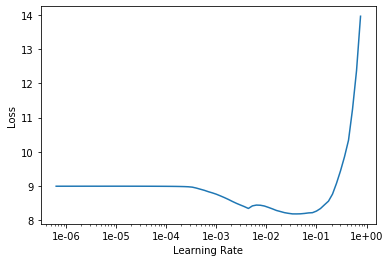

In [10]:
learn.lr_find()
learn.recorder.plot()

# Model Training

In [11]:
# Set hyperparameters
max_lr = 1e-2
moms = (0.5, .75)
pct_strt = 0.02
a_epochs = 10

In [12]:
callbacks = [
    callbacks.SaveModelCallback(
        learn, every='improvement',
        monitor='valid_loss', name='awd_lstm_save_model'
    )
]

In [ ]:
#amit experiments
learn.fit_one_cycle(a_epochs, max_lr, callbacks = callbacks)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.load(model_path/'awd_lstm_do_30pct')

In [ ]:
learn = load_model(df_trn, file = model_path/'awd_lstm_do_30pc.pkl')

/usr/local/lib/python3.6/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


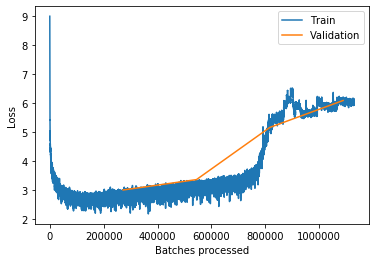

In [14]:
figure_plot = learn.recorder.plot_losses(return_fig=True)

In [ ]:
figure_plot.savefig(fname="awd_lstm_plot_losses.png", format='png')

In [ ]:
from PIL import Image
Image.open('/tf/main/nbs/mdling/awd_lstm/awd_lstm_plot_losses.png')

# Model Evaluation

In [ ]:
print(df_val["query"][50000])
print("\n\n" + df_val["res"][50000])

In [ ]:
print(df_val["query"][75_000])
print("\n\n" + df_val["res"][75_000])

In [17]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.Load(str(data_path/"merged/model.model"))

True

In [ ]:
TEXT = df_val["query"][500]
N_WORDS = 200
N_SENTENCES = 2

In [ ]:
print(TEXT)
df_val["res"][500]

In [ ]:
print(sp.DecodePieces(learn.predict(TEXT, 100, temperature=0.75).split(" ")))

# Evaluation

In [ ]:
learn.predict??

In [18]:
# Grabs entire model's response up until special xxbos token,
# i.e. once model begins a new sentence we consider the model finished with its answer.
def get_res(mdl, inpt, n_toks = 1_000):
    res = mdl.predict(inpt, n_toks, temperature=0.75).split(" ")
    res = sp.DecodePieces(res).split(" ")
    try:
        end_res = res.index("xxbos")
    except:
        end_res = len(res) - 1
    
    res = " ".join(res[:end_res])[len(inpt.replace(" ", '')):]
    
    return res

In [19]:
res = get_res(learn, "public static void main() {return;}<$bug$>", n_toks = 10)
res # [0:len("public static void main() {return;}<$bug$>")]

'no'

In [ ]:
#export
def eval_txt(mdl, ds):
    b1, b2, b3, b4 = [], [], [], []
    meteor = []
    rouge_l = []
    for inpt, lbl in zip(ds["query"], ds["res"]):
        tok_len = len(sp.EncodeAsPieces(inpt))
        if tok_len > 1024:
            continue
            
        pred = get_res(mdl, inpt, n_toks = 10)
        # bleu 1-4
        b1.append(eval_bleu1([lbl], pred))
        b2.append(eval_bleu2([lbl], pred))
        b3.append(eval_bleu3([lbl], pred))
        b4.append(eval_bleu4([lbl], pred))
        
        # meteor
        meteor.append(eval_meteor([lbl], pred))
        
        # rouge
        rouge_l.append(eval_rougeL([lbl], pred))
        
    return b1, b2, b3, b4, meteor, rouge_l

In [20]:
# Evaluation metrics for vulnerability detection - Accuracy, Precision, Recall
def eval_vuln(mdl, tst):
    tps, tns, fps, fns = 0, 0, 0, 0
    tot = 0
    for inpt, lbl in zip(tst["query"], tst["res"]):
        tok_len = len(sp.EncodeAsPieces(inpt))
        if tok_len > 1024:
#             print("Skipping because size is too big", tok_len)
            continue
        pred = get_res(mdl, inpt, n_toks = 10)
        if lbl == "yes":
            if pred == lbl:
                tps += 1
            else: fns += 1
        else:
            if pred == lbl:
                tns += 1
            else: fps += 1
                
        tot += 1
        torch.cuda.empty_cache()
            
    acc   = (tps + tns) / tot
    prec  = tps / (tps + fps) if (tps + fps) != 0 else 0.
    recal = tps / (tps + fns) if (tps + fns) != 0 else 0.
    
    return acc, prec, recal

In [27]:
acc, prec, recal = eval_vuln(learn, df_val[:1000])

In [29]:
acc, prec, recal

(0.7708108108108108, 1.0, 0.7708108108108108)

In [ ]:
len(df_val[:10])

In [ ]:
import torch
torch.cuda.empty_cache()